# Tower Demand Curve for One Renewal Period

## Overview
Find the optimal insurance tower structure — deductible (retention) and maximum limit — across
a range of loss ratios to formulate a demand curve for insurance.  The optimizer maximizes a 75/25 blend of ergodic growth rate and low log-growth volatility, subject to a hard constraint of no more than 0.5% probability of ruin over one renewal year.

The tower is built from fixed layer breakpoints but the optimizer can "squish" it from both ends by choosing where to start (deductible) and where to stop (max limit).

- **Prerequisites**: [optimization/01_optimization_overview](01_optimization_overview.ipynb)
- **Audience**: [Practitioner] / [Developer]

In [1]:
"""Google Colab setup: mount Drive and install package dependencies.

Run this cell first. If prompted to restart the runtime, do so, then re-run all cells.
This cell is a no-op when running locally.
"""
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    NOTEBOOK_DIR = '/content/drive/My Drive/Colab Notebooks/ei_notebooks/optimization'

    os.chdir(NOTEBOOK_DIR)
    if NOTEBOOK_DIR not in sys.path:
        sys.path.append(NOTEBOOK_DIR)

    !pip install ergodic-insurance -q 2>&1 | tail -3
    print('\nSetup complete. If you see numpy/scipy import errors below,')
    print('restart the runtime (Runtime > Restart runtime) and re-run all cells.')

## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import multiprocessing

warnings.filterwarnings("ignore")

from ergodic_insurance.pareto_frontier import (
    Objective, ObjectiveType, ParetoFrontier, ParetoPoint,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = multiprocessing.cpu_count()
print(f"Number of CPU cores: {N_CORES}")  # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

Number of CPU cores: 16


## Part I: Parameter Setup

### Manufacturing Company Configuration

Baseline company parameters (the experiment varies revenue via `revenue_grid`).

In [3]:
# --- Economic Parameters
ATR = 2.0                # Asset turnover ratio
OPERATING_MARGIN = 0.15  # 12% EBIT margin before Insurable Losses
REV_VOL = 0.50           # Revenue volatility (annualized)
INITIAL_ASSETS = 5_000_000

# --- Company Configuration ---
mfg_config = ManufacturerConfig(
    initial_assets=INITIAL_ASSETS,          # $15M total assets
    asset_turnover_ratio=ATR,               # Revenue = Assets Ãƒâ€” turnover = $22.5M
    base_operating_margin=OPERATING_MARGIN, # 12% EBIT margin -> $2.7M/yr operating income
    tax_rate=0.25,                          # 25% corporate tax
    retention_ratio=0.70,                   # 70% earnings retained for growth
)

# Display company profile
revenue = mfg_config.initial_assets * mfg_config.asset_turnover_ratio
ebit = revenue * mfg_config.base_operating_margin
print("=" * 60)
print("MANUFACTURING COMPANY PROFILE")
print("=" * 60)
print(f"Total Assets:          ${mfg_config.initial_assets:>14,.0f}")
print(f"Annual Revenue:        ${revenue:>14,.0f}")
print(f"Operating Income:      ${ebit:>14,.0f}")
print(f"Operating Margin:      {mfg_config.base_operating_margin:>14.1%}")
print(f"Asset Turnover:        {mfg_config.asset_turnover_ratio:>14.1f}x")
print(f"Revenue Volatility:    {REV_VOL:>14}")
print(f"Tax Rate:              {mfg_config.tax_rate:>13.1%}")
print(f"Retention Ratio:       {mfg_config.retention_ratio:>13.1%}")
print("=" * 60)

MANUFACTURING COMPANY PROFILE
Total Assets:          $     5,000,000
Annual Revenue:        $    10,000,000
Operating Income:      $     1,500,000
Operating Margin:               15.0%
Asset Turnover:                   2.0x
Revenue Volatility:               0.5
Tax Rate:                      25.0%
Retention Ratio:               70.0%


### Shared Simulation Infrastructure

Loss model, analytical LEV-based layer pricing, CRN scenario generation, and simulation engine.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from concurrent.futures import ProcessPoolExecutor
import warnings
import logging
import time

# Suppress all warnings and verbose solver logging
warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)

from ergodic_insurance.hjb_solver import (
    StateVariable, ControlVariable, StateSpace,
    LogUtility, PowerUtility, ExpectedWealth,
    HJBProblem, HJBSolver, HJBSolverConfig,
)
from ergodic_insurance.optimal_control import (
    ControlSpace, StaticControl, HJBFeedbackControl,
    TimeVaryingControl, OptimalController,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import (
    ManufacturingLossGenerator, LognormalLoss, ParetoLoss,
)
from ergodic_insurance.insurance_pricing import LayerPricer

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = 40   # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

# =====================================================
# SHARED SIMULATION INFRASTRUCTURE
# =====================================================
# Used by Parts 5, 8, 9, 10, and 11.

# --- Economic Parameters ---
REFERENCE_REVENUE = ATR * INITIAL_ASSETS  # Fixed reference for loss calibration

# --- Loss Scaling ---
# Loss frequency (and CRN loss amounts) scale with the square root of
# revenue.  This keeps the loss drag proportional to the company's
# actual size for both insured and uninsured strategies.
FREQ_SCALING_EXPONENT = 0.75

# --- Amplified Loss Model ---
ATTR_BASE_FREQ = 5
ATTR_SEV_MEAN = 10_000
ATTR_SEV_CV = 10

LG_BASE_FREQ = 1.75
LG_SEV_MEAN = 400_000
LG_SEV_CV = 5

CAT_BASE_FREQ = 0.25
CAT_SEV_ALPHA = 2.01
CAT_SEV_XM = 800_000

LOSS_PARAMS = dict(
    attritional_params={'base_frequency': ATTR_BASE_FREQ,
                        'severity_mean': ATTR_SEV_MEAN,
                        'severity_cv': ATTR_SEV_CV,
                        'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                        'reference_revenue': REFERENCE_REVENUE},
    large_params={'base_frequency': LG_BASE_FREQ,
                  'severity_mean': LG_SEV_MEAN,
                  'severity_cv': LG_SEV_CV,
                  'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                  'reference_revenue': REFERENCE_REVENUE},
    catastrophic_params={'base_frequency': CAT_BASE_FREQ,
                         'severity_alpha': CAT_SEV_ALPHA,
                         'severity_xm': CAT_SEV_XM,
                         'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                         'reference_revenue': REFERENCE_REVENUE},
)

# Quick validation of the loss model
_val_gen = ManufacturingLossGenerator(**LOSS_PARAMS, seed=99)
_val_totals = []
SCENARIOS = 10_000
for _ in range(SCENARIOS):
    _events, _stats = _val_gen.generate_losses(duration=1.0, revenue=REFERENCE_REVENUE)
    _val_totals.append(_stats['total_amount'])
_expected_annual_loss = np.mean(_val_totals)
_operating_income = INITIAL_ASSETS * ATR * OPERATING_MARGIN
print(f"Loss model validation ({SCENARIOS:,.0f} one-year samples):")
print(f"  Expected annual loss:  ${_expected_annual_loss:>12,.0f}")
print(f"  Operating income:      ${_operating_income:>12,.0f}")
print(f"  Loss / Income ratio:   {_expected_annual_loss / _operating_income:.0%}")
print(f"  Std dev annual loss:   ${np.std(_val_totals):>12,.0f}")
print(f"  Max annual loss:       ${np.max(_val_totals):>12,.0f}")
del _val_gen, _val_totals, _events, _stats


# --- Analytical Layer Pricing via LEV ---
# Instead of hardcoded rate-on-line values, we compute actuarially sound
# premiums from the known severity distributions using limited expected
# values (LEVs).  For each layer (attachment a, limit l):
#
#   E[layer loss] = sum_i  freq_i * [LEV_i(a+l) - LEV_i(a)]
#   premium       = E[layer loss] / target_loss_ratio
#   rate_on_line  = premium / limit
#
# This ensures the primary-layer ROL decreases naturally as the Ded
# (retention) rises, producing the genuine cost-vs-variance tradeoff
# that the HJB solver needs.
#
# The pricers are parameterized so that the sensitivity analysis (Part 9)
# can adapt premiums to match the modified loss assumptions being tested.

TARGET_LOSS_RATIO = 0.7  # Normal-market loss ratio
LOSS_RATIO_INFLECTION = 1  # Factor by which the max layer loss ratio differs from the base

def make_layer_pricers(large_freq=LG_BASE_FREQ,
                        large_sev_mean=LG_SEV_MEAN,
                        cur_revenue=REFERENCE_REVENUE) -> tuple:
    """Create a tuple of LayerPricers for a given loss parameterization.

    Frequency scales as (revenue / reference)^0.5, matching the loss
    model's sub-linear revenue scaling.  This keeps premium and loss
    scaling consistent so that insured and uninsured strategies face
    the same proportional cost growth.

    Args:
        large_freq: Large-loss annual frequency (default 1.0).
        large_sev_mean: Large-loss mean severity (default $1M).
        cur_revenue: Current revenue for frequency scaling.

    Returns:
        Tuple of (attritional, large, catastrophic) LayerPricers.
    """
    scale = (cur_revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
    return (
        LayerPricer(LognormalLoss(mean=ATTR_SEV_MEAN, cv=ATTR_SEV_CV),
                    frequency=ATTR_BASE_FREQ * scale),
        LayerPricer(LognormalLoss(mean=large_sev_mean, cv=LG_SEV_CV),
                    frequency=large_freq * scale),
        LayerPricer(ParetoLoss(alpha=CAT_SEV_ALPHA, xm=CAT_SEV_XM),
                    frequency=CAT_BASE_FREQ * scale),
    )


# Default pricers for baseline loss model
DEFAULT_PRICERS = make_layer_pricers()

MIN_LAYER_MIDPOINT = np.mean([0, 5_000_000])
MAX_LAYER_MIDPOINT = np.mean([450_000_000, 500_000_000])

def analytical_layer_premium(attachment: float, limit: float,
                            pricers=None,
                            base_loss_ratio: float,
                            loss_ratio_inflection: float) -> float:
    """Compute actuarial premium for a layer using LEV-based expected losses.

    Premium = E[layer loss] / layer_loss_ratio, where:
      E[layer loss] = sum over components of freq_i * (LEV_i(a+l) - LEV_i(a))

    Args:
        attachment: Layer attachment point.
        limit: Layer limit (width of coverage).
        pricers: Tuple of LayerPricers. Uses DEFAULT_PRICERS if None.
        base_loss_ratio: Desired loss ratio for the layer.
        loss_ratio_inflection: Factor by which the max layer loss ratio  differs from the base.
    """
    
    pricers = pricers or DEFAULT_PRICERS
    expected_loss = sum(p.expected_layer_loss(attachment, limit) for p in pricers)
    cur_layer_midpoint = np.mean([attachment, attachment + limit])
    layer_loss_ratio = base_loss_ratio + \
                        (1.0 / loss_ratio_inflection - 1.0) * base_loss_ratio \
                        * (cur_layer_midpoint - MIN_LAYER_MIDPOINT) \
                        / (MAX_LAYER_MIDPOINT - MIN_LAYER_MIDPOINT)
    return expected_loss / layer_loss_ratio


def analytical_rate_on_line(attachment: float, limit: float,
                            base_loss_ratio: float,
                            loss_ratio_inflection: float,
                            pricers=None) -> float:
    """Compute rate-on-line for a layer: premium / limit."""
    if limit <= 0:
        return 0.0
    return analytical_layer_premium(attachment, 
                                    limit, 
                                    pricers, 
                                    base_loss_ratio, 
                                    loss_ratio_inflection) / limit


# Validate: show how ROL varies across sample attachment points
print(f"\nAnalytical layer pricing (target LR = {TARGET_LOSS_RATIO:.0%}):")
print(f"  {'Attachment':>12s}  {'Limit':>12s}  {'E[Loss]':>12s}  {'Premium':>12s}  {'ROL':>8s}")
print(f"  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*8}")
for _a, _l in [(10_000, 4_990_000), (25_000, 4_975_000), (50_000, 4_950_000),
                (250_000, 4_750_000), (1_000_000, 4_000_000),
                (2_000_000, 3_000_000), (4_000_000, 1_000_000),
                (5_000_000, 20_000_000), (25_000_000, 25_000_000), (50_000_000, 50_000_000)]:
    _el = analytical_layer_premium(_a, _l, LOSS_RATIO, 1.0) * TARGET_LOSS_RATIO
    _p = analytical_layer_premium(_a, _l, LOSS_RATIO, 1.0)
    _r = analytical_rate_on_line(_a, _l, LOSS_RATIO, 1.0)
    print(f"  ${_a:>11,.0f}  ${_l:>11,.0f}  ${_el:>11,.0f}  ${_p:>11,.0f}  {_r:>7.2%}")


# --- Insurance Tower Factory ---
# Premium rates are computed analytically from the loss distribution,
# ensuring that the primary-layer ROL decreases with higher retention.
# The optional `pricers` argument lets the sensitivity analysis pass
# in LayerPricers built from alternative loss assumptions, so that
# premiums stay consistent with the loss environment being tested.

def make_program(ded: float,
                base_loss_ratio: float,
                loss_ratio_inflection: float,
                max_limit: float,
                pricers=None) -> InsuranceProgram:
    """Create 4-layer tower with analytically priced premiums.

    Uses LEV-based layer pricing from severity distributions so that
    rate-on-line adjusts naturally with the retention level.

    Args:
        ded: Deductible.
        max_limit: Maximum coverage limit (top of tower).
        pricers: Tuple of LayerPricers. Uses DEFAULT_PRICERS if None.

    Returns:
        InsuranceProgram with actuarially sound premium loading.
    """
    layer_defs = [
        # (attachment, ceiling, reinstatements)
        (0, 5_000_000, 0),
        (5_000_000, 10_000_000, 0),
        (10_000_000, 25_000_000, 0),
        (25_000_000, 50_000_000, 0),
        (50_000_000, 100_000_000, 0),
        (100_000_000, 150_000_000, 0),
        (150_000_000, 200_000_000, 0),
        (200_000_000, 250_000_000, 0),
        (250_000_000, 300_000_000, 0),
        (300_000_000, 350_000_000, 0),
        (350_000_000, 400_000_000, 0),
        (400_000_000, 450_000_000, 0),
        (450_000_000, 500_000_000, 0),
    ]
    layers = []
    for attach, ceiling, reinst in layer_defs:
        if ded >= ceiling:
            continue  # Skip layers that are fully below the deductible
        if max_limit is not None and ceiling > max_limit:
            continue  # Skip layers that exceed the max limit constraint
        # Now we're within the working layer
        # The deductible is below, the max limit is above
        effective_attach = max(attach, ded)
        limit = ceiling - effective_attach
        if limit <= 0:
            continue
        rol = analytical_rate_on_line(effective_attach, limit, pricers)
        layers.append(EnhancedInsuranceLayer(
            attachment_point=effective_attach,
            limit=limit,
            base_premium_rate=rol,
            reinstatements=reinst,
        ))
    return InsuranceProgram(
        layers=layers,
        deductible=ded,
        name=f"Manufacturing Tower (Ded=${ded:,.0f})",
    )


# --- CRN: Pre-generate Loss Scenarios ---
def generate_loss_pool(n_paths, n_years, reference_revenue=REFERENCE_REVENUE, seed=SEED, specific_loss_params=None):
    """Pre-generate loss scenarios for Common Random Number comparison.
    All strategies will face the exact same loss events and revenue shocks.
    Losses are generated at a fixed reference revenue; the simulation
    engine then scales event amounts by (actual_revenue / reference)^0.5
    so that loss burden grows proportionally with the company.

    Args:
        n_paths: Number of simulation paths.
        n_years: Number of years to simulate.
        reference_revenue: Reference revenue for loss calibration.
        seed: Base seed for random number generation.
        specific_loss_params: A dictionary of loss parameters to use, overriding
                              the global LOSS_PARAMS for this call.
    """
    loss_params_to_use = specific_loss_params if specific_loss_params is not None else LOSS_PARAMS

    ss = np.random.SeedSequence(seed)
    children = ss.spawn(n_paths + 1)

    # Shared revenue shocks
    rev_rng = np.random.default_rng(children[0])
    revenue_shocks = rev_rng.standard_normal((n_paths, n_years))

    # Per-path loss event sequences
    all_losses = []  # [path][year] -> List[LossEvent]
    for i in range(n_paths):
        gen = ManufacturingLossGenerator(
            **loss_params_to_use, # Use the potentially overridden loss params
            seed=int(children[i + 1].generate_state(1)[0] % (2**31)),
        )
        path_losses = []
        for t in range(n_years):
            events, _ = gen.generate_losses(duration=1.0, revenue=reference_revenue)
            path_losses.append(events)
        all_losses.append(path_losses)

    return revenue_shocks, all_losses


# --- CRN Simulation Engine ---
def simulate_with_crn(ded, 
                    base_loss_ratio: float,
                    loss_ratio_inflection: float,
                    max_limit: float,
                    revenue_shocks, loss_pool, n_years=1,
                    initial_assets=INITIAL_ASSETS, pricers=None):
    """Simulate one static-Ded strategy across all CRN paths.

    Uses the library's InsuranceProgram.process_claim() to correctly
    allocate each loss through the insurance tower.

    Loss amounts from the CRN pool are scaled by
    (actual_revenue / REFERENCE_REVENUE)^FREQ_SCALING_EXPONENT so that
    the loss burden grows proportionally with the company.  Premium is
    repriced at actual revenue with the same exponent, keeping the
    cost-of-risk consistent between insured and uninsured strategies.

    Args:
        ded: Deductible.
        revenue_shocks: Pre-generated revenue shocks (n_paths x n_years).
        loss_pool: Pre-generated loss events [path][year] -> List[LossEvent].
        n_years: Simulation horizon.
        initial_assets: Starting wealth.
        pricers: Tuple of LayerPricers for premium calculation.
            Uses DEFAULT_PRICERS if None (baseline loss assumptions).

    Returns:
        paths: array of shape (n_paths, n_years + 1) with asset values.
    """
    n_paths = len(loss_pool)
    paths = np.zeros((n_paths, n_years + 1))
    paths[:, 0] = initial_assets

    # Build program template and get fixed annual premium
    if ded >= 100_000_000:
        # "No insurance" -- skip tower entirely
        annual_premium = 0.0
        use_insurance = False
        program_template = None
    else:
        program_template = make_program(ded, 
                                        base_loss_ratio, 
                                        loss_ratio_inflection, 
                                        max_limit,
                                        pricers=pricers)
        annual_premium = program_template.calculate_premium()
        use_insurance = True

    for i in range(n_paths):
        assets = initial_assets
        for t in range(n_years):
            # Operating income with shared revenue shock
            revenue = assets * ATR * np.exp(
                REV_VOL * revenue_shocks[i, t] - 0.5 * REV_VOL**2
            )
            operating_income = revenue * OPERATING_MARGIN

            # Scale CRN losses to current revenue (sqrt scaling)
            loss_scale = (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT

            # Process losses through insurance tower
            total_retained = 0.0
            if use_insurance:
                new_pricers = make_layer_pricers(cur_revenue=revenue)
                program_update = make_program(ded, 
                                                base_loss_ratio, 
                                                loss_ratio_inflection, 
                                                max_limit,
                                                pricers=new_pricers)
                annual_premium = program_update.calculate_premium()
                program = InsuranceProgram.create_fresh(program_update)
                for event in loss_pool[i][t]:
                    scaled_amount = event.amount * loss_scale
                    result = program.process_claim(scaled_amount)
                    total_retained += result.deductible_paid + result.uncovered_loss
            else:
                for event in loss_pool[i][t]:
                    total_retained += event.amount * loss_scale

            # Net income and asset update
            assets = assets + operating_income - total_retained - annual_premium
            assets = max(assets, 0.0)
            paths[i, t + 1] = assets

    return paths


# Pre-generate the main CRN pool
N_PATHS = 50_000
N_YEARS = 1
print(f"\nPre-generating CRN loss pool ({N_PATHS:,.0f} paths x {N_YEARS} years)...")
t0 = time.time()
CRN_SHOCKS, CRN_LOSSES = generate_loss_pool(n_paths=N_PATHS, n_years=N_YEARS)
print(f"  Done in {time.time() - t0:.1f}s")
print(f"  Shape: {CRN_SHOCKS.shape[0]:,} paths x {CRN_SHOCKS.shape[1]} years")

# Quick sanity: total losses per path-year
_annual_totals = [
    sum(e.amount for e in CRN_LOSSES[i][t])
    for i in range(N_PATHS) for t in range(N_YEARS)
]
print(f"  Mean annual loss: ${np.mean(_annual_totals):,.0f}")
del _annual_totals


Loss model validation (10,000 one-year samples):
  Expected annual loss:  $   1,140,707
  Operating income:      $   1,500,000
  Loss / Income ratio:   76%
  Std dev annual loss:   $   2,329,126
  Max annual loss:       $  70,845,147

Analytical layer pricing (target LR = 70%):
    Attachment         Limit       E[Loss]       Premium       ROL
  ------------  ------------  ------------  ------------  --------
  $     10,000  $  4,990,000  $    959,675  $  1,370,964   27.47%
  $     25,000  $  4,975,000  $    927,801  $  1,325,430   26.64%
  $     50,000  $  4,950,000  $    886,712  $  1,266,732   25.59%
  $    250,000  $  4,750,000  $    691,064  $    987,235   20.78%
  $  1,000,000  $  4,000,000  $    325,441  $    464,915   11.62%
  $  2,000,000  $  3,000,000  $    150,938  $    215,625    7.19%
  $  4,000,000  $  1,000,000  $     29,996  $     42,851    4.29%
  $  5,000,000  $ 20,000,000  $    122,074  $    174,392    0.87%
  $ 25,000,000  $ 25,000,000  $     18,616  $     26,595   

## Part II: Insurance Demand Curve

For each revenue level in `revenue_grid`, we sweep all valid `(ded, max_limit)` pairs
from `ded_grid` × `max_limit_grid` and simulate 10,000 one-year CRN paths.

The optimal tower at each revenue is selected by maximizing a **weighted objective**:
- **75% weight** on annual ergodic growth rate
- **25% weight** on reducing result volatility (std of log-growth)

subject to the **hard constraint** that the probability of ruin does not exceed **1%**.

Losses scale with revenue via a **0.75 exponent**, and the tower is "squished" from both
the deductible (bottom) and the max limit (top) by the optimizer.

In [ ]:
import itertools

ded_grid = np.unique(np.concatenate([
    [0, 10_000, 15_000, 25_000, 50_000, 75_000,
    100_000, 125_000, 150_000, 175_000, 200_000, 250_000,
    300_000, 350_000, 400_000, 450_000, 500_000, 750_000, 1_000_000,
    1_250_000, 1_500_000, 1_750_000, 2_000_000, 2_500_000,
    3_000_000, 3_500_000, 4_000_000, 4_500_000,
    5_000_000, 7_500_000, 10_000_000, 15_000_000,
    20_000_000, 25_000_000, 30_000_000, 35_000_000,
    40_000_000, 45_000_000, 50_000_000],  # landmarks
    np.geomspace(50_000_000, 250_000_000, 30)[1:], # excess range
]))

max_limit_grid = np.unique(np.concatenate([
    [500_000, 750_000, 1_000_000,
    1_250_000, 1_500_000, 1_750_000, 2_000_000, 2_500_000,
    3_000_000, 3_500_000, 4_000_000, 4_500_000,
    5_000_000, 7_500_000, 10_000_000, 15_000_000,
    20_000_000, 25_000_000, 30_000_000, 35_000_000,
    40_000_000, 45_000_000, 50_000_000],  # landmarks
    np.geomspace(50_000_000, 500_000_000, 50)[1:], # excess range
]))

### 3 parameters to sweep: revenue, base loss ratio, and loss ratio inflection factor
# This parameter forms the base demand curve
base_loss_ratio_grid = np.linspace(0.4, 0.9, 11)

# This parameter tests demand sensitivity to upper layer loss ratios
inflection_factor_grid = np.array([
    1.0,
    2.0,
    3.0,
])

# This parameter tests demand sensitivity to company revenue
revenue_grid = np.array([
    5_000_000,
    25_000_000,
    50_000_000,
])

# Grid for parallel sweeping to determine demand curves
scan_grid = list(itertools.product(revenue_grid, base_loss_ratio_grid, inflection_factor_grid))

print(f"Deductible grid:  {len(ded_grid)} values "
        f"(${ded_grid[0]:,.0f} -- ${ded_grid[-1]:,.0f})")
print(f"Max limit grid:   {len(max_limit_grid)} values "
        f"(${max_limit_grid[0]:,.0f} -- ${max_limit_grid[-1]:,.0f})")
print(f"Revenue grid:     {len(revenue_grid)} values "
        f"(${revenue_grid[0]:,.0f} -- ${revenue_grid[-1]:,.0f})")

Deductible grid:  68 values ($0 -- $250,000,000)
Max limit grid:   72 values ($500,000 -- $500,000,000)
Revenue grid:     24 values ($2,000,000 -- $100,000,000)


In [ ]:
from tqdm.auto import tqdm

# Use correct N_CORES (cell 3 value, not the hardcoded 40 in cell 9)
N_CORES = multiprocessing.cpu_count()

# --- Optimization criteria ---
GROWTH_WEIGHT = 0.75       # weight on annual ergodic growth rate
VOL_WEIGHT    = 0.25       # weight on reducing log-growth volatility
RUIN_LIMIT    = 0.005       # hard constraint: P(ruin) <= 1%
SENS_N_PATHS  = 500

warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)


# --- Fixed make_program: truncates layers at max_limit instead of skipping ---
def make_program(ded, 
                base_loss_ratio: float,
                loss_ratio_inflection: float,
                max_limit=None, 
                pricers=None,):
    """Build multi-layer tower truncated by ded (bottom) and max_limit (top).

    The tower uses fixed layer breakpoints at $5M / $25M / $50M / $100M.
    Layers that straddle the deductible or max_limit are truncated (not dropped),
    so the optimizer can smoothly squish the tower from both ends.
    """
    layer_defs = [
        (0, 5_000_000, 0),
        (5_000_000, 10_000_000, 0),
        (10_000_000, 25_000_000, 0),
        (25_000_000, 50_000_000, 0),
        (50_000_000, 100_000_000, 0),
        (100_000_000, 150_000_000, 0),
        (150_000_000, 200_000_000, 0),
        (200_000_000, 250_000_000, 0),
        (250_000_000, 300_000_000, 0),
        (300_000_000, 350_000_000, 0),
        (350_000_000, 400_000_000, 0),
        (400_000_000, 450_000_000, 0),
        (450_000_000, 500_000_000, 0),
    ]
    layers = []
    for attach, ceiling, reinst in layer_defs:
        if ded >= ceiling:
            continue
        if max_limit is not None and max_limit <= attach:
            continue
        effective_attach = max(attach, ded)
        effective_ceiling = min(ceiling, max_limit) if max_limit is not None else ceiling
        limit = effective_ceiling - effective_attach
        if limit <= 0:
            continue
        rol = analytical_rate_on_line(effective_attach,
                                        limit,
                                        pricers,
                                        base_loss_ratio,
                                        loss_ratio_inflection)
        layers.append(EnhancedInsuranceLayer(
            attachment_point=effective_attach,
            limit=limit,
            base_premium_rate=rol,
            reinstatements=reinst,
        ))
    name = f"Tower Ded=${ded:,.0f}"
    if max_limit is not None:
        name += f" Lim=${max_limit:,.0f}"
    return InsuranceProgram(layers=layers, deductible=ded, name=name)


def _optimize_tower_for_revenue(args):
    """Sweep all valid (ded, max_limit) combos for one revenue level.

    Generates a CRN loss pool at this revenue, then simulates each combo
    over SENS_N_PATHS one-year paths.  Returns all records for post-hoc
    optimal selection.
    """
    revenue, base_lr, inf_lr, ded_arr, ml_arr, seed_base = args
    initial_assets = revenue / ATR

    shocks, losses = generate_loss_pool(
        n_paths=SENS_N_PATHS, n_years=1,
        reference_revenue=revenue, seed=seed_base,
    )
    pricers = make_layer_pricers(cur_revenue=revenue)

    records = []
    for ded in ded_arr:
        for ml in ml_arr:
            if ded >= ml:
                continue

            program = make_program(ded, base_lr, inf_lr, max_limit=ml, pricers=pricers)
            premium = program.calculate_premium()
            has_layers = len(program.layers) > 0

            W_T = np.empty(SENS_N_PATHS)
            for i in range(SENS_N_PATHS):
                assets = initial_assets
                rev = assets * ATR * np.exp(
                    REV_VOL * shocks[i, 0] - 0.5 * REV_VOL ** 2
                )
                op_income = rev * OPERATING_MARGIN
                loss_scale = (rev / revenue) ** FREQ_SCALING_EXPONENT

                total_retained = 0.0
                if has_layers:
                    prog = InsuranceProgram.create_fresh(program)
                    for event in losses[i][0]:
                        scaled = event.amount * loss_scale
                        result = prog.process_claim(scaled)
                        total_retained += result.deductible_paid + result.uncovered_loss
                else:
                    for event in losses[i][0]:
                        total_retained += event.amount * loss_scale

                assets += op_income - total_retained - premium
                W_T[i] = max(assets, 0.0)

            log_g = np.log(np.maximum(W_T, 1.0) / initial_assets)
            records.append({
                'revenue': revenue,
                'base_loss_ratio': base_lr,
                'loss_ratio_inflation_factor': inf_lr,
                'initial_assets': initial_assets,
                'ded': ded,
                'max_limit': ml,
                'growth_rate': np.mean(log_g),
                'growth_vol': np.std(log_g),
                'ruin_prob': np.mean(W_T <= 0),
                'premium': premium,
                'mean_wealth': np.mean(W_T),
            })

    return records


# --- Run the experiment ---
inputs = [(rev, base_lr, inf_lr, ded_grid, max_limit_grid, SEED + i)
          for i, (rev, base_lr, inf_lr) in enumerate(scan_grid)]
n_valid = sum(1 for d in ded_grid for m in max_limit_grid if d < m)
print(f"Tower optimization: {len(scan_grid)} combinations x "
      f"~{n_valid} valid (ded, limit) combos x {SENS_N_PATHS:,} paths")
print(f"Parallel on {N_CORES} cores\n")

t0 = time.time()
try:
    from joblib import Parallel, delayed
    results = Parallel(n_jobs=min(N_CORES, len(revenue_grid)), verbose=10)(
        delayed(_optimize_tower_for_revenue)(inp) for inp in inputs
    )
except ImportError:
    print("joblib not available, trying ProcessPoolExecutor...")
    try:
        with ProcessPoolExecutor(max_workers=min(N_CORES, len(revenue_grid))) as ex:
            results = list(tqdm(
                ex.map(_optimize_tower_for_revenue, inputs),
                total=len(inputs), desc="Tower optimization",
            ))
    except Exception:
        print("ProcessPoolExecutor failed, running serially...")
        results = [_optimize_tower_for_revenue(inp)
                   for inp in tqdm(inputs, desc="Tower optimization (serial)")]
except Exception as e:
    print(f"Parallel failed ({e}), running serially...")
    results = [_optimize_tower_for_revenue(inp)
               for inp in tqdm(inputs, desc="Tower optimization (serial)")]

all_records = []
for r in results:
    all_records.extend(r)

elapsed = time.time() - t0
print(f"\nDone in {elapsed:.1f}s ({len(all_records):,} evaluations)")

df_tower = pd.DataFrame(all_records)

# --- Select optimal tower per revenue level ---
optimal_towers = []
for rev in revenue_grid:
    df_rev = df_tower[df_tower['revenue'] == rev]
    feasible = df_rev[df_rev['ruin_prob'] <= RUIN_LIMIT]

    if len(feasible) > 0:
        g = feasible['growth_rate'].values
        v = feasible['growth_vol'].values
        g_rng = max(g.max() - g.min(), 1e-12)
        v_rng = max(v.max() - v.min(), 1e-12)
        scores = (GROWTH_WEIGHT * (g - g.min()) / g_rng
                  + VOL_WEIGHT  * (v.max() - v) / v_rng)
        best_idx = feasible.index[np.argmax(scores)]
    else:
        best_idx = df_rev['ruin_prob'].idxmin()

    row = df_tower.loc[best_idx]
    optimal_towers.append({
        'revenue': rev,
        'optimal_ded': row['ded'],
        'optimal_max_limit': row['max_limit'],
        'growth_rate': row['growth_rate'],
        'growth_vol': row['growth_vol'],
        'ruin_prob': row['ruin_prob'],
        'premium': row['premium'],
        'tower_width': row['max_limit'] - row['ded'],
    })

df_optimal = pd.DataFrame(optimal_towers)

print("\nOptimal Tower by Revenue Level:")
print("=" * 110)
print(f"{'Revenue':>14s}  {'Optimal Ded':>14s}  {'Max Limit':>14s}  "
      f"{'Tower Width':>14s}  {'Growth':>8s}  {'Vol':>8s}  "
      f"{'Ruin':>6s}  {'Premium':>12s}")
print("-" * 110)
for _, row in df_optimal.iterrows():
    print(f"${row['revenue']:>13,.0f}  ${row['optimal_ded']:>13,.0f}  "
          f"${row['optimal_max_limit']:>13,.0f}  ${row['tower_width']:>13,.0f}  "
          f"{row['growth_rate']:>7.4f}  {row['growth_vol']:>7.4f}  "
          f"{row['ruin_prob']:>5.3f}  ${row['premium']:>11,.0f}")
print("=" * 110)

NameError: name 'scan_grid' is not defined

In [7]:
import os

CACHE_DIR = 'cache'
os.makedirs(CACHE_DIR, exist_ok=True)

# Save full experiment grid (zstd-compressed Parquet)
records_path = os.path.join(CACHE_DIR, 'tower_experiment.parquet')
try:
    df_tower.to_parquet(records_path, compression='zstd')
    sz = os.path.getsize(records_path) / 1024
    print(f"Saved experiment grid: {records_path} "
          f"({len(df_tower):,} rows, {sz:.0f} KB)")
except (ImportError, Exception):
    records_path = os.path.join(CACHE_DIR, 'tower_experiment.pkl')
    df_tower.to_pickle(records_path)
    print(f"Saved experiment grid: {records_path} (pickle fallback)")

# Save optimal tower summary
optimal_path = os.path.join(CACHE_DIR, 'optimal_towers.parquet')
try:
    df_optimal.to_parquet(optimal_path, compression='zstd')
    print(f"Saved optimal towers: {optimal_path}")
except (ImportError, Exception):
    optimal_path = os.path.join(CACHE_DIR, 'optimal_towers.pkl')
    df_optimal.to_pickle(optimal_path)
    print(f"Saved optimal towers: {optimal_path} (pickle fallback)")

print(f"\nCache: {os.path.abspath(CACHE_DIR)}")

Saved experiment grid: cache/tower_experiment.parquet (82,896 rows, 3114 KB)
Saved optimal towers: cache/optimal_towers.parquet

Cache: /content/drive/MyDrive/Colab Notebooks/ei_notebooks/optimization/cache


### Optimal Tower Visualization

The chart shows how the optimal insurance tower evolves with company revenue:
- **Lower boundary**: optimal retention (deductible)
- **Upper boundary**: optimal max limit (top of tower)
- **Viridis gradient**: dollar amount within the tower — navy at bottom, yellow at top

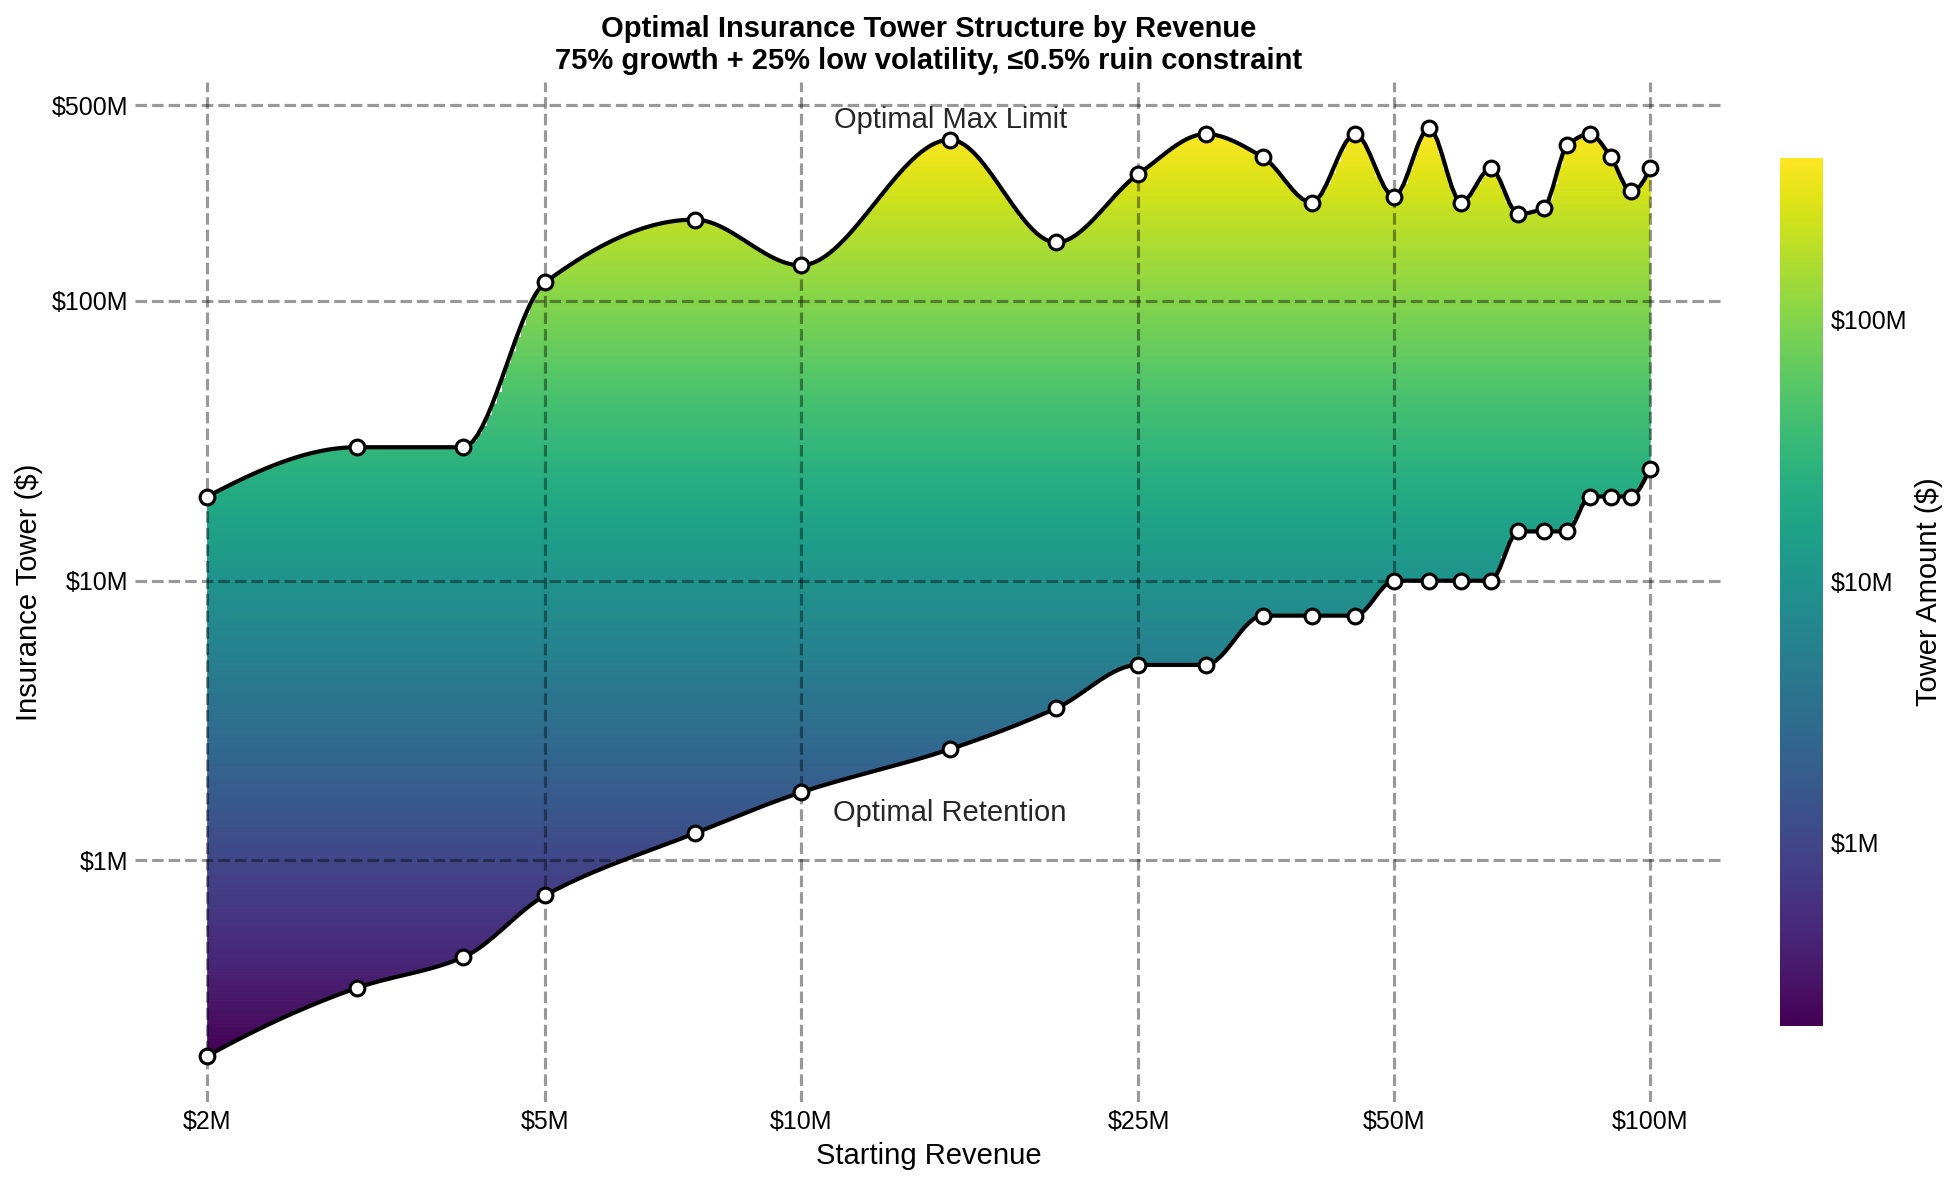


Chart saved to: cache/optimal_tower_by_revenue.png


In [8]:
from scipy.interpolate import PchipInterpolator
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker

fig, ax = plt.subplots(figsize=(14, 8), dpi=150)

# --- Interpolate optimal tower boundaries in log-log space ---
revenues = df_optimal['revenue'].values
ded_vals = np.maximum(df_optimal['optimal_ded'].values, 1_000)  # clip for log scale
lim_vals = df_optimal['optimal_max_limit'].values

log_rev = np.log10(revenues)
log_ded = np.log10(ded_vals)
log_lim = np.log10(lim_vals)

rev_fine = np.geomspace(revenues.min(), revenues.max(), 300)
log_rev_fine = np.log10(rev_fine)

ded_fine = 10 ** PchipInterpolator(log_rev, log_ded)(log_rev_fine)
lim_fine = 10 ** PchipInterpolator(log_rev, log_lim)(log_rev_fine)
ded_fine = np.minimum(ded_fine, lim_fine * 0.99)  # safety: keep gap

# --- Gradient fill with viridis ---
n_bands = 250  # Increased slightly for smoother gradient
y_lo_global = max(ded_fine.min(), 1)
y_hi_global = lim_fine.max()
y_bands = np.geomspace(y_lo_global, y_hi_global, n_bands + 1)

cmap = plt.cm.viridis
norm = LogNorm(vmin=y_lo_global, vmax=y_hi_global)

# --- Tower boundary lines ---
ax.plot(rev_fine, lim_fine, color='black', linewidth=2,
        label='Optimal Max Limit')
ax.plot(rev_fine, ded_fine, color='black', linewidth=2,
        label='Optimal Retention')

# --- Scatter actual optimized grid points ---
ax.scatter(revenues, ded_vals, color='white', edgecolor='black',
           s=50, zorder=5, linewidth=1.5)
ax.scatter(revenues, lim_vals, color='white', edgecolor='black',
           s=50, zorder=5, linewidth=1.5)

# --- Axes formatting ---
ax.set_xscale('log')
ax.set_yscale('log')

def dollar_fmt(x, pos):
    if x >= 1e6:
        return f'${x/1e6:.0f}M'
    elif x >= 1e3:
        return f'${x/1e3:.0f}K'
    return f'${x:.0f}'

def tick_dollar_fmt(x):
    if x >= 1e6:
        return f'${x/1e6:.0f}M'
    elif x >= 1e3:
        return f'${x/1e3:.0f}K'
    return f'${x:.0f}'

ax.xaxis.set_major_formatter(mticker.FuncFormatter(dollar_fmt))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_fmt))
ax.set_xlabel('Starting Revenue', fontsize=14, color='black')
ax.set_ylabel('Insurance Tower ($)', fontsize=14, color='black')
ax.set_title('Optimal Insurance Tower Structure by Revenue\n'
             '75% growth + 25% low volatility, \u22640.5% ruin constraint',
             fontsize=14, fontweight='bold', color='black')

# --- Colorbar ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.85, pad=0.03)
cbar.set_label('Tower Amount ($)', fontsize=14, color='black')
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_fmt))
cbar.ax.tick_params(labelsize=12, colors='black')

# --- Style: black text, white background ---
ax.tick_params(axis='both', labelsize=12, colors='black')
# ax.legend(fontsize=12, loc='best', framealpha=0.9,
#           edgecolor='black', facecolor='white')
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_color('black')

ticks = [2_000_000, 5_000_000, 10_000_000, 25_000_000, 50_000_000, 100_000_000]

ax.set_xticks(ticks)
ax.set_xticklabels([tick_dollar_fmt(rev) for rev in ticks])

for pos in ticks:
    ax.axvline(x=pos, color='black', linestyle='dashed', alpha=0.4)

y_ticks = [1_000_000, 10_000_000, 100_000_000, 500_000_000]

ax.set_yticks(y_ticks)
ax.set_yticklabels([tick_dollar_fmt(rev) for rev in y_ticks])

for pos in y_ticks:
    ax.axhline(y=pos, color='black', linestyle='dashed', alpha=0.4)

plt.tight_layout()
plt.savefig(os.path.join(CACHE_DIR, 'optimal_tower_by_revenue.png'),
            dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nChart saved to: {os.path.join(CACHE_DIR, 'optimal_tower_by_revenue.png')}")